In [1]:
# libraries
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, roc_curve, auc)

import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import plot_model

import numpy as np

In [2]:
labels = ['alert', 'slight_drowsy','mod_drowsy','very_drowsy'] # alert, slightly drowsy, moderately drowsy and very drowsy

In [16]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv('data/features/data_features_train_sampled_filt.csv')
val_df = pd.read_csv('data/features/data_features_val_sampled_filt.csv')
test_df = pd.read_csv('data/features/data_features_test_sampled_filt.csv')

dfs = {'train': train_df, 'val': val_df, 'test': test_df}
dfs_encoded = {}

for name, df in dfs.items():
  # Perform one-hot encoding using get_dummies()
  encoded_columns = pd.get_dummies(df['target'])

  # Reorder the columns of encoded_columns to match the desired order
  encoded_columns = encoded_columns[labels]

  # Concatenate the one-hot encoded columns with the original DataFrame
  df_encoded = pd.concat([df, encoded_columns], axis=1)

  dfs_encoded[name] = df_encoded

train_df = dfs_encoded['train']
val_df = dfs_encoded['val']
test_df = dfs_encoded['test']


In [17]:
print(train_df.shape,val_df.shape,test_df.shape)

(1385, 12) (296, 12) (300, 12)


In [18]:
train_df.head()

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR,image,target,alert,slight_drowsy,mod_drowsy,very_drowsy
0,0,0.461037,0.484335,0.083333,12.000000,0.062207,alert_3_1519.png,alert,1,0,0,0
1,0,0.495449,0.504062,0.071331,10.960894,0.080176,alert_3_640.png,alert,1,0,0,0
2,0,0.451969,0.475556,0.033333,12.000000,0.039810,alert_3_370.png,alert,1,0,0,0
3,0,0.539679,0.603035,0.033333,6.000000,0.051138,alert_1_775.png,alert,1,0,0,0
4,0,0.626182,0.671741,0.033333,6.000000,0.055254,alert_1_617.png,alert,1,0,0,0


In [19]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select the columns you want to scale
columns_to_scale = ["right_EAR", "left_EAR", "blink_duration", "blink_frequency", "MAR"]
# Scale the selected columns
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])
val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])

In [21]:
train_df.describe()

,blinks,right_EAR,left_EAR,blink_duration,blink_frequency,MAR,alert,slight_drowsy,mod_drowsy,very_drowsy
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,0.056318,0.716214,0.722700,0.091366,0.224663,0.093785,0.252708,0.251264,0.244765,0.251264
std,0.230617,0.127847,0.134354,0.093713,0.198450,0.109253,0.434722,0.433896,0.430103,0.433896
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.666177,0.659436,0.030509,0.056919,0.033912,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.737856,0.745265,0.069444,0.173913,0.058092,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.795343,0.809613,0.132679,0.370119,0.104118,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
train_df['target'].value_counts()

alert            350
slight_drowsy    348
very_drowsy      348
mod_drowsy       339
Name: target, dtype: int64

In [23]:
# Save the train, test, and validation DataFrames to separate CSV files
train_df.to_csv('data/features/processed/train_features.csv', index=False)
test_df.to_csv('data/features/processed/test_features.csv', index=False)
val_df.to_csv('data/features/processed/val_features.csv', index=False)

In [69]:
# Save the train, test, and validation DataFrames to separate CSV files
train_df = pd.read_csv('data/features/processed/train_features.csv')
test_df = pd.read_csv('data/features/processed/test_features.csv')
val_df = pd.read_csv('data/features/processed/val_features.csv')

In [24]:
# Create ImageDataGenerators for train, test, and validation sets
train_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values
val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values

# Create train, test, and validation image generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='data/images/sample/train',
    x_col='image',
    y_col=labels,
    batch_size=32,
    target_size=(224, 224),
    class_mode='raw',
    shuffle=True,
    seed=1
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='data/images/sample/test',
    x_col='image',
    y_col=labels,
    batch_size=32,
    target_size=(224, 224),
    class_mode='raw',
    shuffle=False,
    seed=1
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='data/images/sample/val',
    x_col='image',
    y_col=labels,
    batch_size=32,
    target_size=(224, 224),
    class_mode='raw',
    shuffle=False,
    seed=1
)


Found 1385 validated image filenames.
Found 300 validated image filenames.
Found 296 validated image filenames.


In [29]:
X,y = train_generator.next()
print(X.shape, y.shape)

(32, 224, 224, 3) (32, 4)


In [18]:
train_df.drop(columns=['image','target']+labels).columns.tolist()

['blinks', 'right_EAR', 'left_EAR', 'blink_duration', 'blink_frequency', 'MAR']

In [25]:
def custom_generator(image_generator, feature_data, batch_size):
    feature_index = 0
    total_samples = len(feature_data)
    while True:
        batch_images, batch_labels = image_generator.next()
        batch_features = feature_data[feature_index : feature_index + batch_size].values
        if (feature_index + batch_size) > total_samples:
            feature_index = 0
        else:
            feature_index = feature_index + batch_size

        yield ([batch_images, batch_features], batch_labels)

# Create custom generators combining image and feature data
train_generator_with_features = custom_generator(train_generator, train_df.drop(columns=['image','target']+labels), batch_size=32)
test_generator_with_features = custom_generator(test_generator, test_df.drop(columns=['image','target']+labels), batch_size=32)
val_generator_with_features = custom_generator(val_generator, val_df.drop(columns=['image','target']+labels), batch_size=32)


In [30]:
[x1,x2],y=next(test_generator_with_features)
print(x1.shape, x2.shape, y.shape)

(32, 224, 224, 3) (32, 6) (32, 4)


In [179]:
# # Load the pre-trained VGG16 model without the top layers
# vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# vgg16.trainable = False # Set all layers in the VGG16 model as non-trainable

# # Define the image input branch
# image_input = Input(shape=(224, 224, 3)) #(720, 1280, 3)
# vgg_output = vgg16(image_input)
# conv1 = Conv2D(32, (3, 3), activation='relu')(vgg_output)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
# # Add more convolutional and pooling layers as needed

# # Define the numerical feature input branch
# feature_input = Input(shape=(6,))
# dense1 = Dense(64, activation='relu')(feature_input)
# # Add more dense layers as needed

# # Concatenate the outputs from both branches
# concatenated = keras.layers.concatenate([Flatten()(pool1), dense1])

# # Add a final dense layer for prediction
# output = Dense(4, activation='softmax')(concatenated)

# # Create the model
# model = Model(inputs=[image_input, feature_input], outputs=output)

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# # Define the image input branch
# image_input = Input(shape=(224, 224, 3)) #(720, 1280, 3)
# conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
# bn1 = BatchNormalization()(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
# dropout1 = Dropout(0.25)(pool1)
# conv2 = Conv2D(16, (3, 3), activation='relu')(dropout1)
# bn2 = BatchNormalization()(conv2)
# pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
# dropout2 = Dropout(0.25)(pool2)
# conv3 = Conv2D(8, (3, 3), activation='relu')(dropout2)
# bn3 = BatchNormalization()(conv3)
# pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

# # Define the numerical feature input branch
# feature_input = Input(shape=(6,))
# dense1 = Dense(64, activation='relu')(feature_input)
# dropout3 = Dropout(0.25)(dense1)
# dense2 = Dense(32, activation='relu')(dropout3)
# dropout4 = Dropout(0.25)(dense2)
# dense3 = Dense(16, activation='relu')(dropout4)

# # Concatenate the outputs from both branches
# concatenated = keras.layers.concatenate([Flatten()(pool3), dense3])

# # Add a final dense layer for prediction
# output = Dense(4, activation='softmax')(concatenated)

# # Create the model
# model = Model(inputs=[image_input, feature_input], outputs=output)

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Learning rate scheduler
# def lr_scheduler(epoch):
#     initial_lr = 0.001
#     drop_rate = 0.5
#     epochs_drop = 5
#     lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
#     return lr

# scheduler = LearningRateScheduler(lr_scheduler)

In [26]:
# Define the image input branch
image_input = Input(shape=(224, 224, 3)) #(720, 1280, 3)
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
bn1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
conv2 = Conv2D(16, (5, 5), activation='relu')(pool1)
bn2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
conv3 = Conv2D(8, (8, 8), activation='relu')(pool2)
bn3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

# Define the numerical feature input branch
feature_input = Input(shape=(6,))
dense1 = Dense(64, activation='relu')(feature_input)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)

# Concatenate the outputs from both branches
concatenated = keras.layers.concatenate([Flatten()(pool3), dense3])

# Add a final dense layer for prediction
output = Dense(4, activation='softmax')(concatenated)

# Create the model
model = Model(inputs=[image_input, feature_input], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch):
    initial_lr = 0.001
    drop_rate = 0.5
    epochs_drop = 5
    lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

In [27]:
# fit network
history = model.fit(train_generator_with_features,
                    epochs=20,
                    steps_per_epoch=len(train_generator),
                    validation_data=val_generator_with_features,
                    validation_steps= len(val_generator),
                    callbacks=[scheduler])

# 29 mins con 3 epochs => model_3
# 6 mins 34s solo he probado primero con 1 epoch => model_4
# de aquí para abajo con vscode
# 34.1s, 1 epoch, en vscode en vez de google que tarda por tener que ir a drive => model_5
# 8 mins y pico, 1 epoch, con vgg16 => pero ha fallado en la validación al concatenar, estaba tardando mucho tampoco lo iba a usar

# en todo lo de arriba estaban mal los generators, por eso ha fallado el vgg16

# 13 mins 28.8s, ordenador sobrecalentado (por eso tarda), 5 epochs, modelo con más capas => model_6

# 22 mins 46.5s, sigue caliente, 10 epochs y poniendo el epochs drop a 5 que antes no hacía nada, modelo del 6, shuffle true en train_gen => model_7
# al hacer el shuffle ya consigue aprender de los datos de train, pero hay que poner dropout porque en validation va mal
# no parece que el lr esté cambiando, vale es que no lo había ejecutado con el cambio
# mierda he borrado el 7 sin querer, (el que pone 7 es el 8 del model)

# 28 mins 11.6s, sigue caliente, 10 epochs, con el epoch drop a 5 ahora sí, añadiendo dropout => model_8
# el dropout no parece que haga mucho, estoy llegando a accuracy 1 en train y val sigue bajo

# 10 mins solo 1 epoch, sigue caliente, vgg16, 4 epochs por probar, con los arreglos de los generators y el shuffle que antes igual no aprendía porque estaba mal => model_9
# ETA del primero ya son como 9 mins, no lo voy a dejar hasta el final, solo quiero ver el val_accuracy como es

# 4 mins 50.8s, 4 epochs, con las nuevas fotos, sin dropout => model_10

# 6 mins 13s, ordenador de Fer, 15 epochs, con las nuevas fotos, sin dropout => model_11
# 6 mins 37.3s, igual que el 11 pero probando con dropout => model_12
# el tiempo ya será parecido, igual que el 11 (sin dropout), he cambiado los kernel => model_13
# 11 mins 44.8s, el 13 pero con 20 epochs => model_14
# 11 mins 27.3s, metiendo datos de slight_3 último minuto en train => model_15
# como el 15 pero arreglando lo de los features => model_16

# añadiendo v_4 y corrigiendo lo del test

Epoch 1/20
44/44 [==============================] - 39s 864ms/step - loss: 0.4893 - accuracy: 0.8310 - val_loss: 1.1768 - val_accuracy: 0.4358 - lr: 0.0010
Epoch 2/20
44/44 [==============================] - 35s 791ms/step - loss: 0.1063 - accuracy: 0.9617 - val_loss: 1.7981 - val_accuracy: 0.4561 - lr: 0.0010
Epoch 3/20
44/44 [==============================] - 34s 769ms/step - loss: 0.0550 - accuracy: 0.9856 - val_loss: 1.9485 - val_accuracy: 0.3007 - lr: 0.0010
Epoch 4/20
44/44 [==============================] - 34s 771ms/step - loss: 0.0343 - accuracy: 0.9906 - val_loss: 3.6917 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 5/20
44/44 [==============================] - 34s 770ms/step - loss: 0.0198 - accuracy: 0.9949 - val_loss: 2.4877 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/20
44/44 [==============================] - 34s 766ms/step - loss: 0.0105 - accuracy: 0.9978 - val_loss: 1.8928 - val_accuracy: 0.2297 - lr: 5.0000e-04
Epoch 7/20
44/44 [==============================] - 34s 767m

In [28]:
model.save('models/model_17.h5')

In [31]:
np.save('history_17.npy', history.history)

In [60]:
# model = load_model('models/model_13.h5') # model 1 y 2 primeros (1 sin val y 2 con val), con los 9000 y val/test acc 1, epoch 1
# model 3 es con el sample y 3 epochs

In [67]:
model = load_model('models/model_16.h5')

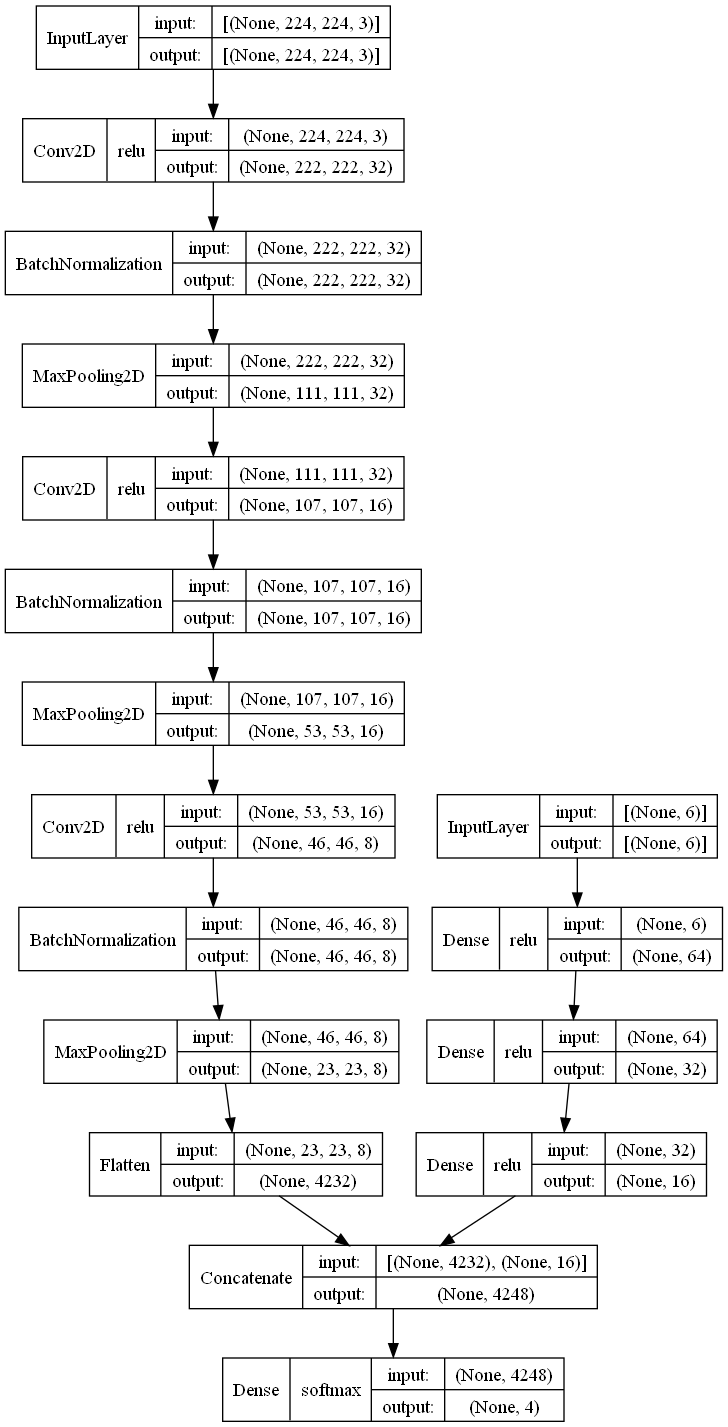

In [ ]:
plot_model(model, to_file="my_model.png", show_shapes=True, show_layer_activations=True,show_layer_names=False, expand_nested=True)

In [32]:
history = np.load("history_17.npy", allow_pickle=True).item()

In [33]:
# Extract the data from history object
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs = list(range(1, len(loss) + 1))

# Create figure with subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"))

# Add training loss and validation loss traces to the first subplot
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name='Train',line=dict(color='blue'), legendgroup='Train', showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=loss, mode='lines', name='Training Loss', line=dict(color='blue'), legendgroup='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines', name='Validation Loss', line=dict(color='red'), legendgroup='Validation', showlegend=False), row=1, col=1)

# Add training accuracy and validation accuracy traces to the second subplot
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines', name='Validation', line=dict(color='red'), legendgroup='Validation', showlegend=True), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=accuracy, mode='lines', name='Training Accuracy', line=dict(color='blue'), legendgroup='Train', showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines', name='Validation Accuracy', line=dict(color='red'), legendgroup='Validation', showlegend=False), row=1, col=2)

# Update layout
fig.update_layout(height=500, width=1100, legend=dict(x=0.85, y=0.1))
fig.update_xaxes(title_text="Epochs", row=2, col=1)
fig.update_yaxes(title_text="Accuracy", row=2, col=1)

# Show the figure
fig.show()

In [34]:
prediction = model.predict(test_generator_with_features, steps=len(test_generator))
# 4 min 56s => model_3
# 2s => model_4
# 2.6s => model_5
# 13.9s => model_6 (ordenador sobrecalentado no sé si afectará)
# 8.4s => model_7  (sigue caliente)
# 3.3s => model_8 (sigue caliente)
# 5.7s => model_10
# 1.5s => model_11 (Fer)

10/10 [==============================] - 1s 134ms/step


In [35]:
test_pred = np.argmax(prediction, axis=1)
test_pred.shape

(300,)

In [36]:
test_true_values = test_df[labels].to_numpy()
test_true = np.argmax(test_true_values, axis=1)
test_true.shape

(300,)

In [37]:
accuracy = accuracy_score(test_true, test_pred)
accuracy
# model_3
# en test sigue teniendo un 100% accuracy ?????
# añadir dropout o regularización?
# igual sigue siendo demasiado parecido, durante el mes ir cargando el resto de mins de los vídeos
# intentar liar a alguien para grabarles también

# model_4
# ya da un accuracy malo como quería
# añadir más capas a la red (maybe vgg16)
# y también más epochs que solo he puesto 1
# 0.18 o así

# model_6
# 0.284

# model_7
# 0.3545

# model_8
# 0.197

# model_11
# 0.7726 por fin algo decente

# model_12
# 0.6254 el dropout es demasiado

# model_13
# 0.8127090301003345 => los generator algo va mal, se ve que no se está reiniciando bien

# model_15
# 0.9220338983050848

# model_16
# 0.9121621621621622

0.8933333333333333

In [38]:
print(classification_report(test_true,test_pred, target_names=labels, digits=4))


               precision    recall  f1-score   support

        alert     0.9605    0.9733    0.9669        75
slight_drowsy     0.7579    0.9600    0.8471        75
   mod_drowsy     0.9153    0.7200    0.8060        75
  very_drowsy     0.9857    0.9200    0.9517        75

     accuracy                         0.8933       300
    macro avg     0.9048    0.8933    0.8929       300
 weighted avg     0.9048    0.8933    0.8929       300



In [39]:
# Métricas obtenidas del classification report
precision = [1.0, 1.0, 0.7374, 1.0]
recall = [1.0, 0.9589, 1.0, 0.6933]
f1_score = [1.0, 0.979, 0.8488, 0.8189]

# Redondear los valores de las métricas a 3 decimales
precision = np.round(precision, decimals=3)
recall = np.round(recall, decimals=3)
f1_score = np.round(f1_score, decimals=3)

labels = ['alert', 'slight_drowsy', 'mod_drowsy', 'very_drowsy']
metrics = ['Precisión', 'Recall', 'F1-score']
colors = ['teal', 'mediumaquamarine', 'cornflowerblue']

# Crear la figura y agregar las barras
fig = go.Figure()

for i, metric in enumerate([precision, recall, f1_score]):
    fig.add_trace(go.Bar(
        name=metrics[i],
        x=labels,
        y=metric,
        marker_color=colors[i],
        text=metric,
        textposition='auto',
        textfont=dict(color='white',size=18)
    ))


# Configurar el diseño del gráfico
fig.update_layout(
    # title='Métricas del Classification Report',
    xaxis=dict(title="Clases", title_font=dict(size=20), tickfont=dict(size=18)),
    yaxis=dict(title="Valor", title_font=dict(size=20), tickfont=dict(size=16)),
    barmode='group',
    legend=dict(
        x=0.82,
        y=0.08,
        font=dict(size=18)
    ),
    height=600,
    width=1100
)

# Mostrar el gráfico
fig.show()


In [40]:
# Construct a visualization for the confusion matrix
z_test = confusion_matrix(test_true,test_pred)

# reformat the matrix
z_test[[0,1,2,3],:] = z_test[[3,2,1,0],:]

x = ['alert','slight_drowsy','mod_drowsy','very_drowsy']
y = ['very_drowsy','mod_drowsy', 'slight_drowsy', 'alert']

def format_text(z):
    """
    This function receives the confusion matrix values and formats the text
    to display in the matrix with the value and percentage of total data.
    """
    return f'{z}<br>({z / np.sum(z_test) * 100:.1f}%)'

z_text = np.vectorize(format_text)(z_test)

heatmap = ff.create_annotated_heatmap(z_test, x=x, y=y, annotation_text=z_text, colorscale='teal')
heatmap.update_layout(height=400,width=650,
                      xaxis=dict(title="Predicted Label", title_font=dict(size=18), tickfont=dict(size=14)),
                      yaxis=dict(title="True Label", title_font=dict(size=18), tickfont=dict(size=14)))
# Modify the font size of the annotations
for annotation in heatmap.layout.annotations:
    annotation.font.size = 13
heatmap.show()

In [160]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Obtener las curvas ROC y los valores AUC para cada clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(test_true_values[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Obtener la curva ROC global
fpr["micro"], tpr["micro"], _ = roc_curve(test_true_values.ravel(), prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Crear la figura y agregar las curvas ROC
fig = go.Figure()

# Agregar la curva ROC global
fig.add_trace(go.Scatter(
    x=fpr["micro"],
    y=tpr["micro"],
    name=f'ROC global (AUC = {roc_auc["micro"]:.4f})',
    mode='lines'
))

# Agregar las curvas ROC para cada clase
for i in range(len(labels)):
    fig.add_trace(go.Scatter(
        x=fpr[i],
        y=tpr[i],
        name=f'ROC clase {labels[i]} (AUC = {roc_auc[i]:.4f})',
        mode='lines'
    ))

# Configurar el diseño del gráfico
fig.update_layout(
    #title='Curvas ROC',
    xaxis=dict(title="Tasa de Falsos Positivos", title_font=dict(size=18), tickfont=dict(size=14)),
    yaxis=dict(title="Tasa de Verdaderos Positivos", title_font=dict(size=18), tickfont=dict(size=14)),
    legend=dict(
        x=0.3,
        y=0.1,
        font=dict(size=14)
    ),
    height=500,
    width=700
)

# Mostrar el gráfico
fig.show()


In [41]:
cont=0
for i in range(295):
    if test_true[i]==2 and test_pred[i]==1:
        cont+=1
        print(test_df.iloc[i]['image'])

mod_drowsy_2_1748.png
mod_drowsy_2_1148.png
mod_drowsy_2_1155.png
mod_drowsy_2_1780.png
mod_drowsy_2_1099.png
mod_drowsy_2_1480.png
mod_drowsy_2_1106.png
mod_drowsy_2_1602.png
mod_drowsy_2_1104.png
mod_drowsy_2_1654.png
mod_drowsy_2_1693.png
mod_drowsy_2_1708.png
mod_drowsy_2_1671.png
mod_drowsy_2_1772.png
mod_drowsy_2_1472.png
mod_drowsy_2_1115.png
mod_drowsy_2_1313.png
mod_drowsy_2_1107.png
mod_drowsy_2_1764.png
mod_drowsy_2_1142.png
